In [1]:
import pandas as pd
import numpy as np

In [10]:
# 获得特征矩阵和标签矩阵
def get_Mat(path):
    dataSet = pd.read_table(path,header = None)
    xMat = np.mat(dataSet.iloc[:,:-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

In [47]:
xMat , yMat = get_Mat('simpdata.txt')

In [48]:
xMat

matrix([[1. , 2.1],
        [1.5, 1.6],
        [1.3, 1. ],
        [1. , 1. ],
        [2. , 1. ]])

In [49]:
yMat

matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [50]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simhei'] # 可以输入中文
# 在Jupyter内部显示图
%matplotlib inline 

# 数据集可视化函数
def showPlot(xMat,yMat):
    x = np.array(xMat[:,0]) # 横坐标
    y = np.array(xMat[:,1]) # 纵坐标
    label = np.array(yMat) # 标签
    plt.scatter(x,y,c=label)
    plt.title('单层决策树测试数据')
    plt.show()

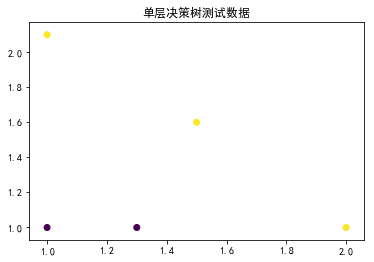

In [51]:
showPlot(xMat,yMat)

In [17]:
"""
函数功能：单层决策树分类函数
参数说明：
    xMat ：数据矩阵
    i ： 第i列，也就是第几个特征
    Q ： 阈值
    S :  标志
返回 :
    re : 分类结果
"""
def Classify0(xMat,i,Q,S):
    re = np.ones((xMat.shape[0],1)) # 初始化re为1
    if S == 'lt':
        re[xMat[:,i] <= Q] = -1     # 如果小于阈值，赋为-1
    else:
        re[xMat[:,i] > Q ] = -1     # 如果大于阈值，赋为-1
    return re

In [52]:
"""
函数功能：找到数据集上最佳的单层决策树
参数说明：
    xMat ：特征矩阵
    yMat : 标签矩阵
    D : 样本权重
返回：
    bestStump : 最佳单层决策树信息
    minE : 最小误差
    bestClas : 最佳的分类结果
"""
def get_Stump(xMat,yMat,D):
    m,n = xMat.shape # m为样本个数，n为特征数
    Steps = 10 # 初始化步长
    bestStump = {} # 用字典形式来存储树桩信息
    bestClas = np.mat(np.zeros((m,1))) # 初始化分类结果为1
    minE = np.inf # 最小误差初始化正无穷大
    for i in range(n): # 遍历所有特征
        Min = xMat[:,i].min() # 找到特征中的最小值
        Max = xMat[:,i].max() # 找到特征中的最大值
        stepSize = (Max - Min) / Steps # 计算步长
        for j in range(-1 , int(Steps)+1): 
            for S in ['lt','gt']: # 大于和小于的情况，均遍历
                Q = (Min + j * stepSize) # 计算阈值
                re = Classify0(xMat , i , Q ,S) # 计算分类结果
                err = np.mat(np.ones((m,1))) # 初始化误差矩阵
                err[re == yMat] = 0 # 分类正确的，赋值为0
                eca = D.T * err # 计算加权的错误率
                if eca < minE: # 找到误差最小的分类方式
                    minE = eca
                    bestClas = re.copy()
                    bestStump['特征列'] = i
                    bestStump['阈值'] = Q
                    bestStump['标志'] = S
    return bestStump , minE , bestClas

In [24]:
m = xMat.shape[0]
D = np.mat(np.ones((m,1))/m)
bestStump , minE , bestClas = get_Stump(xMat,yMat,D)

In [25]:
bestStump

{'标志': 'lt', '特征列': 0, '阈值': 1.3}

In [26]:
minE

matrix([[0.2]])

In [27]:
bestClas

array([[-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.]])

In [74]:
"""
函数功能：基于单层决策树的AdaBoost训练过程
参数说明：
    xMat: 特征矩阵
    yMat：标签矩阵
    maxC：最大迭代次数
返回：
    weakClass：弱分类信息
    aggClass：类别估计值（其实就是更改了标签的估计值）
"""
def Ada_train(xMat,yMat,maxC = 40):
    weakClass = []
    m = xMat.shape[0]
    D = np.mat(np.ones((m,1)) / m ) # 初始化权重
    aggClass = np.mat(np.zeros((m,1)))
    for i in range(maxC):
        Stump,error,bestClas = get_Stump(xMat,yMat,D) # 构建单层决策树
        alpha = float(0.5 * np.log((1 - error) / max(error , 1e-16))) # 计算弱分类器权重,max(error,1e-16)是为了防止错误率为0而造成分母为0的情况发生
        Stump['alpha'] = np.round(alpha , 2) # 存储弱学习算法权重，保留两位小数
        weakClass.append(Stump) # 存储单层决策树
        #预测正确为exp(-alpha),预测错误为exp(alpha)
        #即增大分类错误样本的权重，减少分类正确的数据点权重
        expon = np.multiply(-1 * alpha * yMat , bestClas) # 计算e的指数项
        D = np.multiply(D , np.exp(expon))  
        D = D / D.sum() # 根据样本权重公式，更新样本权重
        aggClass += alpha * bestClas # 更新类别估计值
        aggErr = np.multiply(np.sign(aggClass) != yMat , np.ones((m,1))) # 计算误差
        errRate = aggErr.sum() / m 
        #print("误差：",errRate)
        if errRate == 0 : # 误差为0，退出循环
            break
    return weakClass , aggClass
        

In [67]:
weakClass, aggClass =Ada_train(xMat, yMat, maxC = 40) 

误差： 0.2
误差： 0.2
误差： 0.0


In [68]:
weakClass 

[{'alpha': 0.69, '标志': 'lt', '特征列': 0, '阈值': 1.3},
 {'alpha': 0.97, '标志': 'lt', '特征列': 1, '阈值': 1.0},
 {'alpha': 0.9, '标志': 'lt', '特征列': 0, '阈值': 0.9}]

In [63]:
aggClass

matrix([[ 1.17568763],
        [ 2.56198199],
        [-0.77022252],
        [-0.77022252],
        [ 0.61607184]])

In [69]:
""" 
函数功能：AdaBoost分类函数 
参数说明：    
    data: 待分类样例    
    classifys:训练好的分类器 
返回:    
    分类结果 
    """ 
def AdaClassify(data,weakClass):
    dataMat = np.mat(data)
    m = dataMat.shape[0]
    aggClass = np.mat(np.zeros((m,1)))
    for i in range(len(weakClass)): #遍历所有分类器，进行分类        
        classEst = Classify0(dataMat,
                             weakClass[i]['特征列'],
                             weakClass[i]['阈值'],
                             weakClass[i]['标志'])
        aggClass += weakClass[i]['alpha'] * classEst
        #print(aggClass)    
    return np.sign(aggClass)

In [70]:
AdaClassify([0,0],weakClass)

matrix([[-1.]])

In [77]:
def calAcc(maxC = 40):
    train_xMat , train_yMat = get_Mat('horseColicTraining2.txt')
    m = train_xMat.shape[0]
    weakClass , aggClass = Ada_train(train_xMat , train_yMat , maxC)
    yhat = AdaClassify(train_xMat,weakClass)
    train_re = 0
    for i in range(m):
        if yhat[i] == train_yMat[i]:
            train_re += 1
    train_acc = train_re / m
    print(f'训练集准确率{train_acc}')
    
    test_re = 0
    test_xMat , test_yMat = get_Mat('horseColicTest2.txt')
    n = test_xMat.shape[0]
    yhat = AdaClassify(test_xMat , weakClass)
    for i in range(n):
        if yhat[i] == test_yMat[i]:
            test_re += 1
    test_acc = test_re / n
    print(f'测试集准确率{test_acc}')
    return train_acc,test_acc

In [78]:
calAcc(maxC = 40)

训练集准确率0.802675585284281
测试集准确率0.8059701492537313


(0.802675585284281, 0.8059701492537313)

In [81]:
Cycles = [1,10,50,100,1000,10000]
train_acc = []
test_acc = []
for maxC in Cycles:
    a,b = calAcc(maxC)
    train_acc.append(round(a*100 , 2))
    test_acc.append(round(b*100,2))
df = pd.DataFrame({"分类器数目":Cycles,
                  "训练集准确率":train_acc,
                  "测试集准确率":test_acc})
df

训练集准确率0.7157190635451505
测试集准确率0.7313432835820896
训练集准确率0.7658862876254181
测试集准确率0.7611940298507462
训练集准确率0.8093645484949833
测试集准确率0.7910447761194029
训练集准确率0.8093645484949833
测试集准确率0.7761194029850746
训练集准确率0.8595317725752508
测试集准确率0.7313432835820896
训练集准确率0.8963210702341137
测试集准确率0.6716417910447762


,分类器数目,训练集准确率,测试集准确率
0,1,71.57,73.13
1,10,76.59,76.12
2,50,80.94,79.10
3,100,80.94,77.61
4,1000,85.95,73.13
5,10000,89.63,67.16
